In [1]:
import numpy as np
import matplotlib.pyplot as plt

from shapely.geometry import LineString, Polygon
from tqdm import tqdm

from l5kit_conflict.pickle.io import load_potential_conflict_pickle, report_AVHV_conflicts, report_HVHV_conflicts
from l5kit_conflict.filter.helper import multiline_to_single_line, multi2singleLineString
from l5kit_conflict.analysis.conflict import Conflict
from l5kit_conflict.analysis.trajectory import Trajectory
from l5kit_conflict.analysis.post_process import post_process
from l5kit_conflict.analysis.utils import compute_position_based_velocities, three_sigma_smoothing

np.set_printoptions(suppress=True)
plt.style.use("ggplot")

D:\github\lyft_intersection\l5kit\l5kit\l5kit\dataset\select_agents.py:31: UserWarning: Windows detected. BLOSC_NOLOCK has not been set as it causes memory leaks on Windows.However, writing the mask with this config may be inconsistent.
  warnings.warn(


In [2]:
%%time

# load dataset
delta_time = 10 

print("[1/4] Loading AVHV datasets ...")
AVHV_val_conflict_dataset = load_potential_conflict_pickle(dataset_type="AVHV", dataset_name="validate", delta_time=delta_time)
HVHV_val_conflict_dataset = load_potential_conflict_pickle(dataset_type="HVHV", dataset_name="validate", delta_time=delta_time)

print("[2/4] Loading HVHV datasets ...")
AVHV_train_conflict_dataset = load_potential_conflict_pickle(dataset_type="AVHV", dataset_name="train2", delta_time=delta_time)
HVHV_train_conflict_dataset = load_potential_conflict_pickle(dataset_type="HVHV", dataset_name="train2", delta_time=delta_time)

print("[3/4] Processing AVHV datasets ...")
AVHV_conflicts = []
AVHV_conflicts = AVHV_conflicts + post_process(AVHV_val_conflict_dataset, "val")
AVHV_conflicts = AVHV_conflicts + post_process(AVHV_train_conflict_dataset, "train")

print("[4/4] Processing HVHV datasets ...")
HVHV_conflicts = []
HVHV_conflicts = HVHV_conflicts + post_process(HVHV_val_conflict_dataset, "val")
HVHV_conflicts = HVHV_conflicts + post_process(HVHV_train_conflict_dataset, "train")

[1/4] Loading AVHV datasets ...
[2/4] Loading HVHV datasets ...
[3/4] Processing AVHV datasets ...
[4/4] Processing HVHV datasets ...
CPU times: total: 25.5 s
Wall time: 25.5 s


In [8]:
# %%time

truncate = False
n_frames_truncated = 10
#############################################################

print("[1/2] Calculating indictors based on HVHV dataset ...")

HVHV_PETs = []
HVHV_leader_vs, HVHV_follower_vs = [], []
HVHV_leader_average_vs, HVHV_follower_average_vs = [], []
HVHV_MaxReqDecs, HVHV_MeanReqDecs = [], []

for conflict in tqdm(HVHV_conflicts):

    is_success, req_decs = conflict.req_dec(truncate, n_frames_truncated)
    
    if is_success:
        HVHV_PETs.append(conflict.PET)
        HVHV_leader_vs.append(conflict.first_veh_speed_at_conflict)
        HVHV_follower_vs.append(conflict.second_veh_speed_at_conflict)
        HVHV_leader_average_vs.append(conflict.first_veh_average_speed)
        HVHV_follower_average_vs.append(conflict.second_veh_average_speed)
        HVHV_MaxReqDecs.append(np.max(req_decs))
        HVHV_MeanReqDecs.append(np.mean(req_decs))
    else:
        continue
        
##############################################################

print("[2/2] Calculating indictors based on AVHV dataset ...")

AVHV_PETs, HVAV_PETs = [], []
AVHV_leader_vs, HVAV_leader_vs = [], []
AVHV_follower_vs, HVAV_follower_vs = [], []
AVHV_leader_average_vs, HVAV_leader_average_vs = [], []
AVHV_follower_average_vs, HVAV_follower_average_vs = [], []
AVHV_MaxReqDecs, HVAV_MaxReqDecs = [], []
AVHV_MeanReqDecs, HVAV_MeanReqDecs = [], []

for conflict in tqdm(AVHV_conflicts):

    is_success, req_decs = conflict.req_dec(truncate, n_frames_truncated)
    
    if is_success:
        PET = conflict.PET
        first_conflict_speed = conflict.first_veh_speed_at_conflict
        second_conflic_speed = conflict.second_veh_speed_at_conflict
        first_veh_average_speed = conflict.first_veh_average_speed
        second_veh_average_speed = conflict.second_veh_average_speed
        if conflict.is_first_AV:
            AVHV_PETs.append(PET)
            AVHV_leader_vs.append(first_conflict_speed)
            AVHV_follower_vs.append(second_conflic_speed)
            AVHV_leader_average_vs.append(first_veh_average_speed)
            AVHV_follower_average_vs.append(second_veh_average_speed)
            AVHV_MaxReqDecs.append(np.max(req_decs))
            AVHV_MeanReqDecs.append(np.mean(req_decs))
            
        else:
            HVAV_PETs.append(PET)
            HVAV_leader_vs.append(first_conflict_speed)
            HVAV_follower_vs.append(second_conflic_speed)
            HVAV_leader_average_vs.append(first_veh_average_speed)
            HVAV_follower_average_vs.append(second_veh_average_speed)
            HVAV_MaxReqDecs.append(np.max(req_decs))
            HVAV_MeanReqDecs.append(np.mean(req_decs))
    else:
        continue

[1/2] Calculating indictors based on HVHV dataset ...


100%|██████████████████████████████████████████████████████| 724/724 [00:02<00:00, 281.16it/s]


[2/2] Calculating indictors based on AVHV dataset ...


100%|██████████████████████████████████████████████████████| 646/646 [00:03<00:00, 179.84it/s]


Draw plots: x: PET, y: conflict speed, z: mean req dec ...


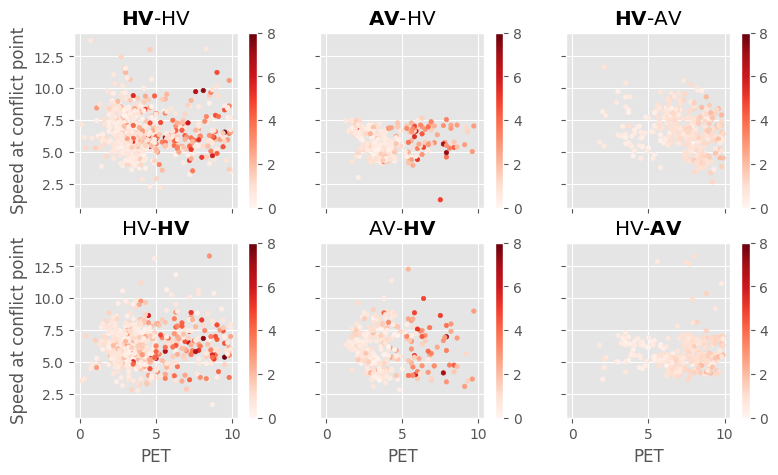

In [9]:
print("Draw plots: x: PET, y: conflict speed, z: mean req dec ...")

fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharey=True, sharex=True)

sca00 = axs[0, 0].scatter(x=HVHV_PETs, y=HVHV_leader_vs, s=10, marker="o", c=HVHV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)
sca01 = axs[0, 1].scatter(x=AVHV_PETs, y=AVHV_leader_vs, s=10, marker="o", c=AVHV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)
sca02 = axs[0, 2].scatter(x=HVAV_PETs, y=HVAV_leader_vs, s=10, marker="o", c=HVAV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)

sca10 = axs[1, 0].scatter(x=HVHV_PETs, y=HVHV_follower_vs, s=10, marker="o", c=HVHV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)
sca11 = axs[1, 1].scatter(x=AVHV_PETs, y=AVHV_follower_vs, s=10, marker="o", c=AVHV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)
sca12 = axs[1, 2].scatter(x=HVAV_PETs, y=HVAV_follower_vs, s=10, marker="o", c=HVAV_MeanReqDecs, cmap="Reds", vmin=0, vmax=8)

# subfigure titles
axs[0, 0].set_title(r"$\bf{HV}$-HV")
axs[0, 1].set_title(r"$\bf{AV}$-HV")
axs[0, 2].set_title(r"$\bf{HV}$-AV")

axs[1, 0].set_title(r"HV-$\bf{HV}$")
axs[1, 1].set_title(r"AV-$\bf{HV}$")
axs[1, 2].set_title(r"HV-$\bf{AV}$")

# x axis
axs[1, 0].set_xlabel("PET")
axs[1, 1].set_xlabel("PET")
axs[1, 2].set_xlabel("PET")

# y axis
axs[0, 0].set_ylabel("Speed at conflict point")
axs[1, 0].set_ylabel("Speed at conflict point")
# axs[0, 0].set_ylabel("Speed at conflict point")

# colorbars
plt.colorbar(sca00, ax=axs[0, 0])
plt.colorbar(sca01, ax=axs[0, 1])
plt.colorbar(sca02, ax=axs[0, 2])
plt.colorbar(sca00, ax=axs[1, 0])
plt.colorbar(sca01, ax=axs[1, 1])
plt.colorbar(sca02, ax=axs[1, 2])

plt.show()

Draw plots: x: PET, y: conflict speed, z: max req dec ...


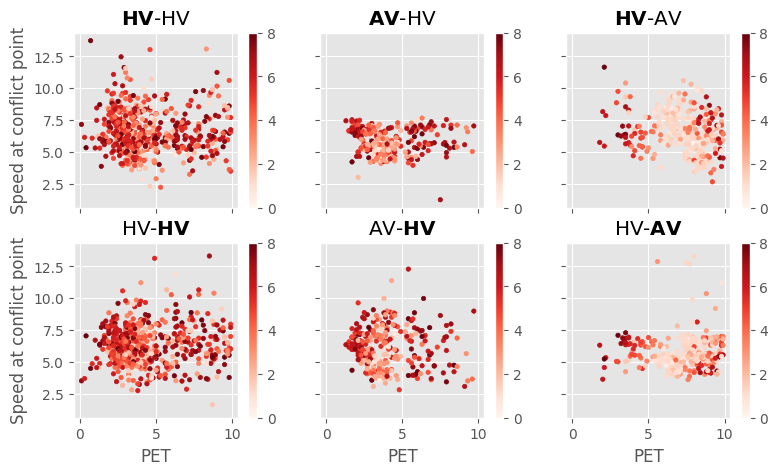

In [5]:
print("Draw plots: x: PET, y: conflict speed, z: max req dec ...")

fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharey=True, sharex=True)

sca00 = axs[0, 0].scatter(x=HVHV_PETs, y=HVHV_leader_vs, s=10, marker="o", c=HVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca01 = axs[0, 1].scatter(x=AVHV_PETs, y=AVHV_leader_vs, s=10, marker="o", c=AVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca02 = axs[0, 2].scatter(x=HVAV_PETs, y=HVAV_leader_vs, s=10, marker="o", c=HVAV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)

sca10 = axs[1, 0].scatter(x=HVHV_PETs, y=HVHV_follower_vs, s=10, marker="o", c=HVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca11 = axs[1, 1].scatter(x=AVHV_PETs, y=AVHV_follower_vs, s=10, marker="o", c=AVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca12 = axs[1, 2].scatter(x=HVAV_PETs, y=HVAV_follower_vs, s=10, marker="o", c=HVAV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)

# subfigure titles
axs[0, 0].set_title(r"$\bf{HV}$-HV")
axs[0, 1].set_title(r"$\bf{AV}$-HV")
axs[0, 2].set_title(r"$\bf{HV}$-AV")

axs[1, 0].set_title(r"HV-$\bf{HV}$")
axs[1, 1].set_title(r"AV-$\bf{HV}$")
axs[1, 2].set_title(r"HV-$\bf{AV}$")

# x axis
axs[1, 0].set_xlabel("PET")
axs[1, 1].set_xlabel("PET")
axs[1, 2].set_xlabel("PET")

# y axis
axs[0, 0].set_ylabel("Speed at conflict point")
axs[1, 0].set_ylabel("Speed at conflict point")
# axs[0, 0].set_ylabel("Speed at conflict point")

# colorbars
plt.colorbar(sca00, ax=axs[0, 0])
plt.colorbar(sca01, ax=axs[0, 1])
plt.colorbar(sca02, ax=axs[0, 2])
plt.colorbar(sca00, ax=axs[1, 0])
plt.colorbar(sca01, ax=axs[1, 1])
plt.colorbar(sca02, ax=axs[1, 2])

plt.show()

Draw plots: x: PET, y: conflict speed, z: max req dec ...


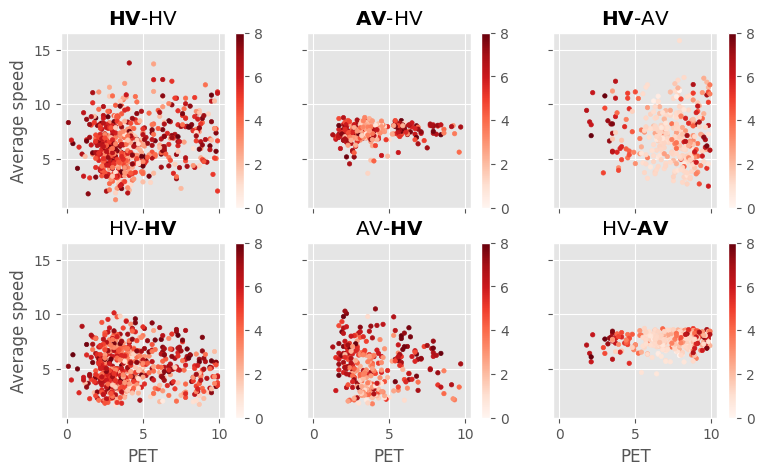

In [6]:
print("Draw plots: x: PET, y: conflict speed, z: max req dec ...")

fig, axs = plt.subplots(2, 3, figsize=(9, 5), sharey=True, sharex=True)

sca00 = axs[0, 0].scatter(x=HVHV_PETs, y=HVHV_leader_average_vs, s=10, marker="o", c=HVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca01 = axs[0, 1].scatter(x=AVHV_PETs, y=AVHV_leader_average_vs, s=10, marker="o", c=AVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca02 = axs[0, 2].scatter(x=HVAV_PETs, y=HVAV_leader_average_vs, s=10, marker="o", c=HVAV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)

sca10 = axs[1, 0].scatter(x=HVHV_PETs, y=HVHV_follower_average_vs, s=10, marker="o", c=HVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca11 = axs[1, 1].scatter(x=AVHV_PETs, y=AVHV_follower_average_vs, s=10, marker="o", c=AVHV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)
sca12 = axs[1, 2].scatter(x=HVAV_PETs, y=HVAV_follower_average_vs, s=10, marker="o", c=HVAV_MaxReqDecs, cmap="Reds", vmin=0, vmax=8)

# subfigure titles
axs[0, 0].set_title(r"$\bf{HV}$-HV")
axs[0, 1].set_title(r"$\bf{AV}$-HV")
axs[0, 2].set_title(r"$\bf{HV}$-AV")

axs[1, 0].set_title(r"HV-$\bf{HV}$")
axs[1, 1].set_title(r"AV-$\bf{HV}$")
axs[1, 2].set_title(r"HV-$\bf{AV}$")

# x axis
axs[1, 0].set_xlabel("PET")
axs[1, 1].set_xlabel("PET")
axs[1, 2].set_xlabel("PET")

# y axis
axs[0, 0].set_ylabel("Average speed")
axs[1, 0].set_ylabel("Average speed")
# axs[0, 0].set_ylabel("Speed at conflict point")

# colorbars
plt.colorbar(sca00, ax=axs[0, 0])
plt.colorbar(sca01, ax=axs[0, 1])
plt.colorbar(sca02, ax=axs[0, 2])
plt.colorbar(sca00, ax=axs[1, 0])
plt.colorbar(sca01, ax=axs[1, 1])
plt.colorbar(sca02, ax=axs[1, 2])

plt.show()